# TUTORIAL ON THE TOOLBOX `pLearningTools`

by Sebastian T. Glavind, June 2020

# Gibbs sampling for parameter learning from partially observed data

This notebook considers how to use the toolbox `pLearningTools` to learn the parameter distributions of a discrete Bayesian network model using Gibbs sampling, when the graph structure (DAG) and discretization policy for continuous variables are defined. The graph structure and discretization policy were found in a previous tutorial: *Dynamic discretization and structure learning from partially observed data*, which will be the basis for this tutorial.


## Prelude

In [21]:
library(bnlearn) # Package for learning bayesian networks (BNs)
library(gRain) # The inplementation makes used of the gRain package for inference in the Gibbs sampler
library(doParallel) # package for parallel computing
source("../MyToolboxes/pLearningTools.R") # load toolbox from source location

## Data and input

In this tutorial, we use the publicly available [sachs](https://www.bnlearn.com/book-crc/) data set.

### Raw data

In [22]:
DATA_org = read.table("../Discretize&sLearn/sachs.data.txt", header = T) # load continuous data set (data frame) from source location
DATA = DATA_org
nodes = names(DATA) # variable names

### Simulate missing data

In [23]:
set.seed(123)

m_DATA = as.matrix(DATA) # convert to matrix in order to perform matrix operations
m_n_D = length(m_DATA); # length of the unfolded array nrow*ncol
n_missing = floor(0.1*m_n_D) # no. of missing data
id_missing = arrayInd(sample(m_n_D, size = n_missing, replace = F), dim(m_DATA)) # indices of missing data
DATA[id_missing] = NA # convert input at these indices to NA

### Discrete data, discretization boundaries and BN model (from previous tutorial)

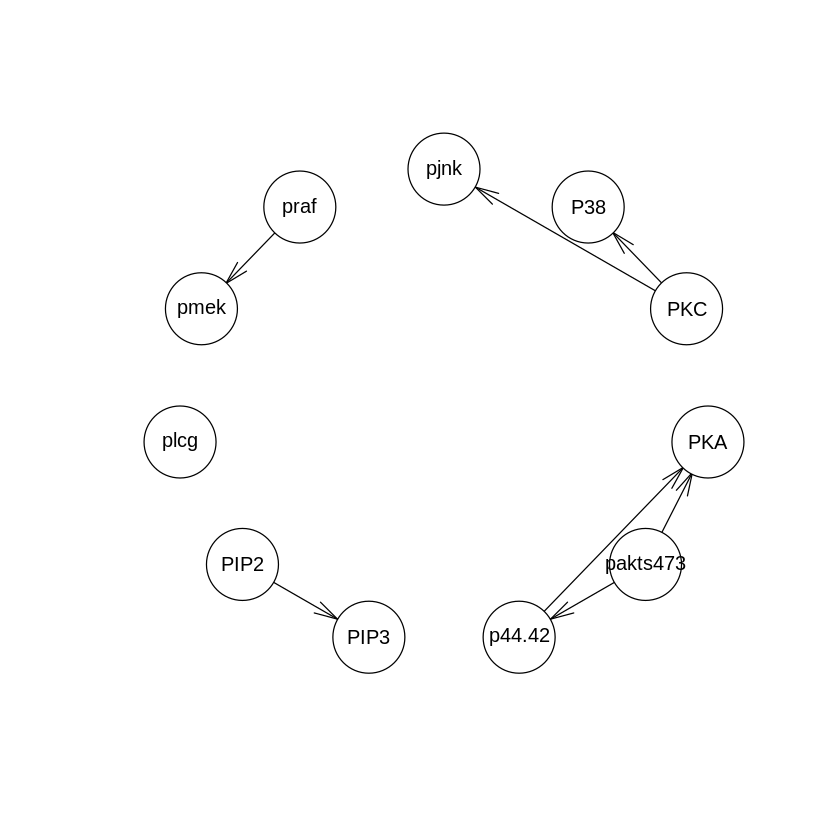

In [24]:
load("BNs_sLearn_partiallyObs.rda")

plot(RES1$BN)

In [25]:
summary(RES1$dDATA, maxsum = 20)

          praf              pmek              plcg              PIP2    
 (-Inf,40.7]:264   (-Inf,17.9]:190   (-Inf,13.2]:257   (-Inf,80.2]:494  
 (40.7,65.5]:254   (17.9,24.9]:212   (13.2,20.7]:255   (80.2,146] :159  
 (65.5, Inf]:254   (24.9,56]  :325   (20.7, Inf]:255   (146, Inf] :112  
 NA's       : 81   (56, Inf]  : 49   NA's       : 86   NA's       : 88  
                   NA's       : 77                                      
                                                                        
          PIP3             p44.42           pakts473           PKA     
 (-Inf,16.1]:257   (-Inf,9.61]:235   (-Inf,22.9]:259   (-Inf,134]: 25  
 (16.1,32.8]:248   (9.61,15.1]:157   (22.9,35.5]:259   (134,688] :565  
 (32.8, Inf]:250   (15.1,28.2]:264   (35.5, Inf]:254   (688, Inf]:182  
 NA's       : 98   (28.2, Inf]:112   NA's       : 81   NA's      : 81  
                   NA's       : 85                                     
                                                         

## Parameter learning

Having defined the graph structure and discretization, we can quantify the model parameters using Bayesian statistics with the Dirichlet equivalent uniform priors. In this regard we assume both global and local parameter independence, see e.g. Koller and Friedman (2009) for further details. Moreover, due to the missing data in this example, we will need to assume a missingness mechanism, and employ a learning algorithm that can deal with missing data. In this tutorial, we will assume that the data is missing at random and employ Gibbs sampling for parameter learning, see e.g. Koller and Friedman (2009) for further details.

***
D. Koller and N. Friedman, Probabilistic graphical models: principles and techniques. MIT Press, 2009.
***


### Imaginary sample size for Dirichlet prior

In [26]:
# # Imaginary sample size
n_iss = 1 # current recommendation, see Ueno (2010)

***
M.  Ueno,  “Learning  networks  determined  by  the  ratio  of  prior  and  data,”  in Proceedings of 26th Conference on Uncertainty in Artificial Intelligence, 2010, pp. 1–8
***

### Gibbs sampling

In [27]:
BN = RES1$BN; # dag structure
fitted0 = RES1$FITTED; # initalization of fitted BN (bnlearn)
junction0 = compile(as.grain(fitted0)) # fitted BN (gRain)
dData0 = RES1$dDATAimp; # initalization of data set (could also be simulated using fitted0)
dData = RES1$dDATA; # data set with missings
n_inst = nrow(dData); # data instances

# same for all iterations: i,j
id_NA = which(is.na(dData), arr.ind=TRUE) # NA enteries in dData (original data set)

In [28]:
no_cores <- detectCores() - 2 # no. cores to use

dDATA_list = list(); dDATA_list[[1]] = dData0; # collect generated complete data sets
bnFIT_list = list(); bnFIT_list[[1]] = fitted0; # collect corr. bn.fit objects

In [29]:
set.seed(42)

# This implementation should work on both Windows and Linux
for (i in 1:100){
#   print(paste0("iteration ", i))
  
  if (i == 1){
    dData1 = dData0; # initial data set
    junction1 = junction0; # initial, fitted BN (gRain)
  }
  
  # initialize cluster
  no_cores <- detectCores() # no. of cores avaliable
  cl <- makeCluster(no_cores-2)
  # cl = makePSOCKcluster(no_cores-2)
  clusterExport(cl, c('id_NA', 'dData1', 'nodes', 'junction1')) # send input to slaves
  junk1 = clusterEvalQ(cl, library(gRain)) # load package to workers
  
  # # Impute missing values 
  data_ij_list = parLapply(cl, 1:n_inst, function(j){
    na_inst_j = which(id_NA[,1] %in% j) # NAs in instance j of the data set
    n_NAj = length(na_inst_j) # no of NAs in instance j
    xj = as.matrix(dData1[j, ]); # instance, j (matrix - usuable in gRain)
    if (n_NAj > 0){
      for (k in 1:n_NAj){
        id_NAjk = id_NA[na_inst_j[k], ]
        node_xjk = nodes[id_NAjk[2]] # node in instance j,k
        jres1k = setEvidence(junction1, nodes = nodes[-id_NAjk[2]], states = xj[-id_NAjk[2]]) # define evidence (NB! Actually, only obs of mb is needed)
        QG1k = querygrain(jres1k, nodes = node_xjk)[[node_xjk]] # Variable distribution given evidence: P(xj | ej)
        state_xjk = sample(attr(QG1k, "dimnames")[[node_xjk]], size = 1, replace = FALSE, prob = QG1k); # sample from states of xj, given P(xj | ej)
        xj[id_NAjk[2]] = state_xjk; # update instance vector
      }
    }
    res = xj;
    return(res)
  })
  stopCluster(cl) # stop cluster
  data_ij_matrix = do.call(rbind, data_ij_list) # arrange outputs in a matrix
  dData1[1:n_inst,] = as.data.frame(data_ij_matrix)[1:n_inst,] # update discrete date set
  
  # Fit parameters
  PC1 = posterior_counts(bn_map = fitted0, ddata = dData1, n_iss = n_iss) # //*pLearningTools*//
  pSample1 = myDirichletSampler(PC = PC1) # //*pLearningTools*//
  bnFIT1 = custom.fit(BN, dist = pSample1) # fitted BN (bnlearn object)
  junction1 = compile(as.grain(bnFIT1)) # fitted BN (gRain)
  
  # Book keeping
  bnFIT_list[[i+1]] = bnFIT1;
  dDATA_list[[i+1]] = dData1;
}

In [33]:
# save(bnFIT_list, dDATA_list, file='pLearn_Gibbs_partiallyObs_n100.rda')
# load('pLearn_Gibbs_partiallyObs_n100.rda')

### Endnotes

The samples can now be used for inference in fully specified BN models (graph and parameters), whereby we account for parameter uncertainties in the inferences

The details on how to conduct inference in Bayesian networks are covered in the tutorial on inference in Bayesian networks (*Inference with general bn.fit objects*), but a small example is given below.


#### Small example on posterior inference accounting for parameters uncertainties

In [39]:
#  Query: P(pjnk = "(-Inf,14.6]")
Ppjnk1 = c()
for (n in 1:length(bnFIT_list)){
    junc_i = compile(as.grain(bnFIT_list[[n]]))
    # P(pjnk)
    QGinf_i = querygrain(junc_i, nodes = c("pjnk"), type = "marginal")
    # P(pjnk = "(-Inf,14.6]")
    Ppjnk1 = c(Ppjnk1, QGinf_i$pjnk[1])
}

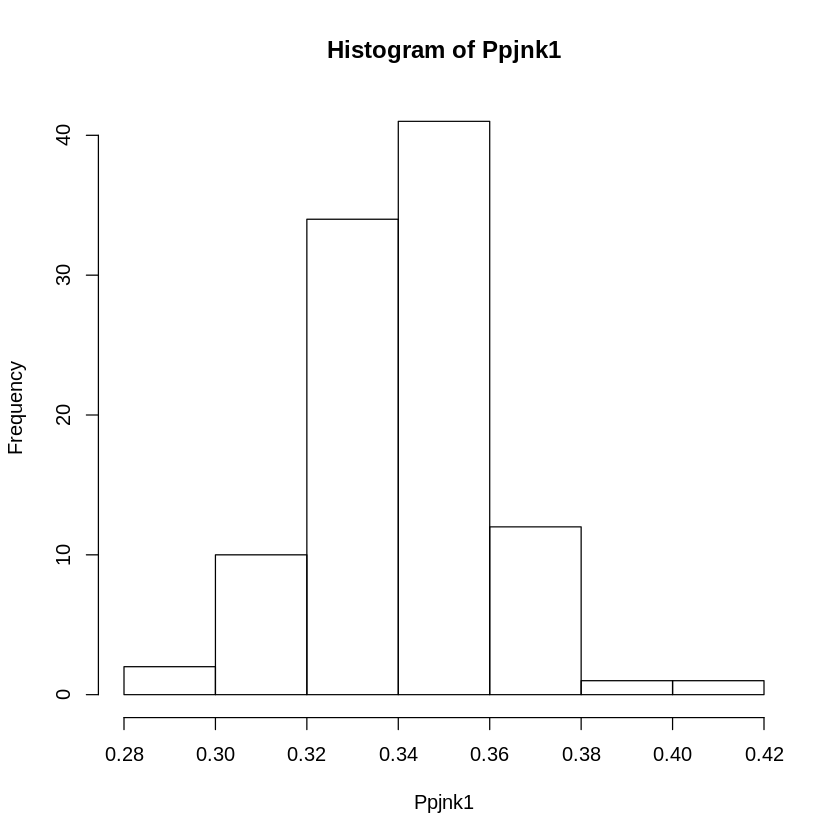

In [40]:
hist(Ppjnk1)

In [41]:
# save(bnFIT_list, dDATA_list, file='pLearn_Gibbs_partiallyObs_n100.rda')